In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [2]:
from b2heavy.FnalHISQMetadata import params as mData

In [3]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites, find_eps_cut
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [5]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

JKFIT = True

In [6]:
ENSEMBLE_LIST = ['Coarse-2','Coarse-1','Coarse-Phys','Fine-1']
MOMLIST       = ['100','200','300','400']
RATIO_LIST    = ['xfstpar','RA1','ZRA1','XV','R0','R1']

In [7]:
Rs = []
for ens in ENSEMBLE_LIST:
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}
        for rat in RATIO_LIST:
            try:
                fit,res = read_config_fit(
                    tag  = f'fit3pt_config_{ens}_{rat}_{mom}',
                    path = DATA_2PT
                )
                r = res['ratio'][0]
            except FileNotFoundError:
                r = None
            aux[rat] = r

            if rat=='xfstpar':
                try:
                    aux['wrecoil'] = (1+r**2)/(1-r**2)
                except TypeError:
                    aux['wrecoil'] = None
        Rs.append(aux)

Rs = pd.DataFrame(Rs).set_index(['ensemble','mom'])
Rs

xfstpar      wrecoil   RA1    XV    R0
ensemble    mom                                            
Coarse-2    100  -0.1036(65)   1.0217(27)  None  None  None
            200   -0.199(14)    1.082(12)  None  None  None
            300   -0.253(30)    1.137(35)  None  None  None
            400         None         None  None  None  None
Coarse-1    100   -0.096(24)   1.0187(95)  None  None  None
            200   -0.175(31)    1.063(23)  None  None  None
            300   -0.241(47)    1.123(51)  None  None  None
            400         None         None  None  None  None
Coarse-Phys 100  -0.0514(47)  1.00530(98)  None  None  None
            200  -0.1028(60)   1.0214(25)  None  None  None
            300  -0.1519(82)   1.0473(52)  None  None  None
            400   -0.199(10)   1.0826(89)  None  None  None
Fine-1      100   -0.084(22)   1.0141(74)  None  None  None
            200   -0.143(14)   1.0419(84)  None  None  None
            300   -0.206(17)    1.089(15)  None  None  None
            400   -0.264(48)    1.150(59)  None  None  None

In [120]:
FF = []
for ens in ENSEMBLE_LIST:
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}

        w   = Rs['wrecoil'].loc[ens,mom]
        RA1 = Rs['RA1'].loc[ens,mom]
        XV  = Rs['XV'].loc[ens,mom]

        if w is None:
            continue
        
        aux['wrecoil'] = w
        aux['hA1']     = 2*RA1/(w+1)
        aux['hV']      = 2*RA1/np.sqrt(w**2-1) * XV

        FF.append(aux)

FF = pd.DataFrame(FF).set_index(['ensemble','mom'])
FF

wrecoil          hA1           hV
ensemble    mom                                      
Coarse-2    100  1.0245(26)    0.404(67)    0.269(56)
            200  1.0834(84)   0.0407(62)   0.0301(68)
            300   1.142(25)  0.00197(51)  0.00143(43)
Coarse-1    100  1.0172(78)    0.576(45)     0.41(15)
            200   1.054(14)    0.158(20)    0.122(39)
            300   1.104(27)   0.0213(28)   0.0153(32)
Coarse-Phys 100  1.0056(14)    0.704(61)    0.540(93)
            200  1.0220(29)    0.404(68)    0.296(54)
            300  1.0479(61)    0.159(41)    0.113(30)
            400   1.082(11)   0.0410(87)   0.0292(68)
Fine-1      100  1.0124(50)    0.557(39)    0.355(78)
            200   1.043(10)    0.185(35)    0.126(30)
            300   1.088(17)   0.0350(28)   0.0249(34)
            400   1.137(43)  0.00398(66)  0.00303(74)

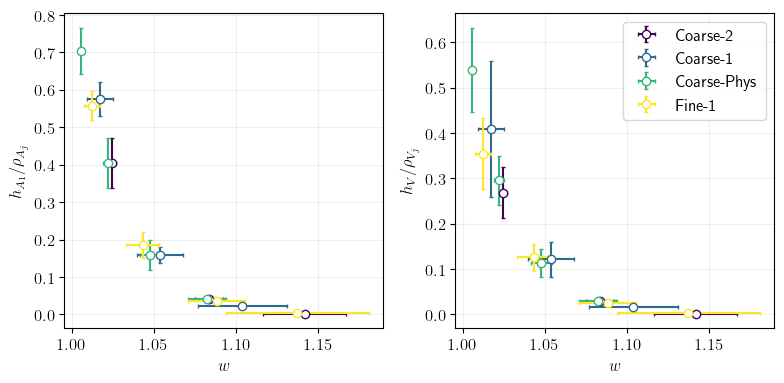

In [149]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,2,figsize=(8,4),sharex=True)


color = plt.cm.viridis(np.linspace(0,1,len(ENSEMBLE_LIST)))

for i,ens in enumerate(ENSEMBLE_LIST):
    ax[0].errorbar(
        gv.mean(FF['wrecoil'].loc[ens].values),
        gv.mean(FF['hA1'].loc[ens].values),
        xerr = gv.sdev(FF['wrecoil'].loc[ens].values),
        yerr = gv.sdev(FF['hA1'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    ax[1].errorbar(
        gv.mean(FF['wrecoil'].loc[ens].values),
        gv.mean(FF['hV'].loc[ens].values),
        xerr = gv.sdev(FF['wrecoil'].loc[ens].values),
        yerr = gv.sdev(FF['hV'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    # ax.errorbar(xin+off,gv.mean(yin),gv.sdev(yin),fmt=mrk[i%2], ecolor=color, mfc='w', color=color, capsize=2.5,alpha=alpha)

ax[0].set_ylabel(r'$h_{A_1}/\rho_{A_j}$')
ax[0].set_xlabel(r'$w$')
ax[0].grid(alpha=0.2)

ax[1].legend()
ax[1].set_ylabel(r'$h_V/\rho_{V_j}$')
ax[1].set_xlabel(r'$w$')
ax[1].grid(alpha=0.2)

plt.tight_layout()
plt.savefig(f'/Users/pietro/Desktop/ff.pdf')
